In [1]:
#@authors: Siyu (Emily) Lei, Kai Lee, Nathan Liu, Vincent Qiu

# import necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Load, Merge, Parse Embeddings, Handle Missing Data

In [4]:
%pip install swifter

# --- Import libraries ---
import pandas as pd
import numpy as np
import ast
import swifter
from tqdm import tqdm
tqdm.pandas()

# Step 1: Load datasets
df_places = pd.read_csv("Original-Datasets/places.csv")
df_userPlace = pd.read_csv("Original-Datasets/user_place.csv")
df_users = pd.read_csv("Original-Datasets/users.csv")

# Step 2: Merge datasets
df_merged = pd.merge(df_userPlace, df_places, on="place_id", how="left")

# Step 3: Safely parse embeddings with swifter + progress bar
df_merged['embedding'] = df_merged['embedding'].swifter.progress_bar(True).apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else np.nan
)

# Step 4: Drop rows missing critical info
critical_columns = ['user_id', 'place_id', 'embedding']
df_merged = df_merged.dropna(subset=critical_columns).reset_index(drop=True)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Pandas Apply: 100%|██████████| 117191/117191 [07:43<00:00, 253.06it/s]


Separate Cold Start Users (<3 Places)

In [5]:
# Step 5: Count number of places per user
user_place_counts = df_merged.groupby('user_id').size().reset_index(name='place_count')

# Step 6: Split into regular users and cold-start users
regular_users = user_place_counts[user_place_counts['place_count'] >= 3]['user_id']
cold_start_users = user_place_counts[user_place_counts['place_count'] < 3]['user_id']

# Step 7: Separate regular and cold-start users
df_regular = df_merged[df_merged['user_id'].isin(regular_users)].copy()
df_coldstart = df_merged[df_merged['user_id'].isin(cold_start_users)].copy()

print(f"Regular users: {len(regular_users)}, Cold-start users: {len(cold_start_users)}")


Regular users: 1275, Cold-start users: 0


Average Embeddings (For Regular Users)

In [6]:
# Step 8: Group by user_id and average their embeddings
user_embeddings = df_regular.groupby('user_id')['embedding'].apply(
    lambda x: np.mean(np.vstack(x), axis=0)
).reset_index()

# Step 9: Add city info if available
if 'city' in df_regular.columns:
    user_city = df_regular.groupby('user_id')['city'].agg(lambda x: x.mode()[0]).reset_index()
    user_embeddings = pd.merge(user_embeddings, user_city, on='user_id', how='left')


Clustering (Taste-Based) - Kmeans

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 10: Prepare feature matrix
X = np.vstack(user_embeddings['embedding'].values)

# Step 11: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 12: KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

user_embeddings['cluster'] = labels


HDBSCAN - Clustering

In [8]:
%pip install hdbscan
from hdbscan import HDBSCAN 
from sklearn.preprocessing import StandardScaler
import hdbscan

# Step 10: Prepare feature matrix
X = np.vstack(user_embeddings['embedding'].values)

# Step 11: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 12: HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1)
labels = clusterer.fit_predict(X_scaled)

user_embeddings['cluster'] = labels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Tsne then DBSCAN then visualization

tsne_cluster
-1      11
 0      62
 1    1202
Name: count, dtype: int64
Number of user embeddings: 1275
Number of dots plotted: 1275
(1275, 5)


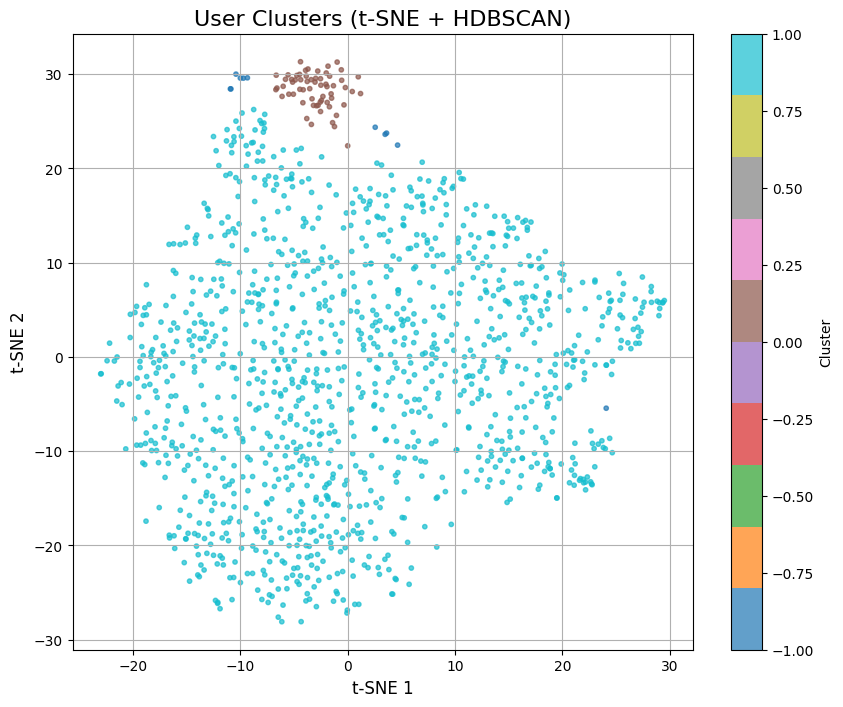

In [11]:
# --- Import necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan
from IPython.display import display

# --- Step 1: Prepare features (your user embeddings) ---
X = np.vstack(user_embeddings['embedding'].values)

# --- Step 2: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 3: Apply t-SNE (reduce to 2D) ---
X_tsne = TSNE(
    n_components=2,        # 2D output
    perplexity=30,          # typical range 5–50 (controls local vs global balance)
    random_state=42,
    learning_rate='auto',   # let it automatically tune learning rate
    init='random'           # random init is standard for t-SNE
).fit_transform(X_scaled)

# --- Step 4: Cluster on t-SNE output ---
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1)
tsne_labels = clusterer.fit_predict(X_tsne)
user_embeddings['tsne_cluster'] = tsne_labels

# Count number of users in each cluster
cluster_counts = user_embeddings['tsne_cluster'].value_counts().sort_index()
print(cluster_counts)
print("Number of user embeddings:", len(user_embeddings))
print("Number of dots plotted:", len(user_embeddings))
print(user_embeddings.shape)




# --- Step 5: Add t-SNE coordinates and cluster labels to user_embeddings ---
user_embeddings['tsne_x'] = X_tsne[:, 0]
user_embeddings['tsne_y'] = X_tsne[:, 1]
user_embeddings['tsne_cluster'] = tsne_labels

# --- Step 6: Plot t-SNE clusters ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    user_embeddings['tsne_x'],
    user_embeddings['tsne_y'],
    c=user_embeddings['tsne_cluster'],
    cmap='tab10',
    s=10,
    alpha=0.7
)

plt.title('User Clusters (t-SNE + HDBSCAN)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Cluster-> Dataframe

In [12]:
# --- Step 1: Merge cluster labels into the full merged dataframe ---
df_with_clusters = pd.merge(df_merged, user_embeddings[['user_id', 'tsne_cluster']], on='user_id', how='left')

# --- Step 2: Drop the 'embedding' column because it's huge and you don't want it ---
columns_to_keep = [
    'user_id', 'place_id', 'status', 'name', 'latitude', 'longitude',
    'tags', 'short_description', 'description', 'emoji', 'key_words',
    'city', 'postal_code', 'neighborhood', 'tsne_cluster'  # KEEP cluster info too
]
df_with_clusters = df_with_clusters[columns_to_keep]

# --- Step 3: Remove outliers (cluster = -1) ---
df_with_clusters = df_with_clusters[df_with_clusters['tsne_cluster'] != -1]

# --- Step 4: Split into two clean DataFrames ---
cluster_0_df = df_with_clusters[df_with_clusters['tsne_cluster'] == 0].reset_index(drop=True)
cluster_1_df = df_with_clusters[df_with_clusters['tsne_cluster'] == 1].reset_index(drop=True)

# --- Step 5: Export each cluster to Excel ---
cluster_0_df.to_excel("cluster_0_users.xlsx", index=False)
cluster_1_df.to_excel("cluster_1_users.xlsx", index=False)

# --- Step 6: (Optional) Display heads ---
print("\n--- Cluster 0 DataFrame ---")
display(cluster_0_df.head())

print("\n--- Cluster 1 DataFrame ---")
display(cluster_1_df.head())



--- Cluster 0 DataFrame ---


,user_id,place_id,status,name,latitude,longitude,tags,short_description,description,emoji,key_words,city,postal_code,neighborhood,tsne_cluster
0,user_4,place_11,want to try,Place_11,40.70896,-73.92297,"{bar,night_club}",multi-room club,Four distinct areas offer different musical vi...,🎵,"{""music venue"",dynamic,lively,industrial,""mult...",new_york,11237.0,Brooklyn,0
1,user_4,place_14,want to try,Place_14,40.72290,-73.97865,{bar},retro disco,70s-themed spot featuring plush couches and a ...,🪩,"{""disco bar"",""dance club"",funky,retro,dancing,...",new_york,10009.0,Alphabet City,0
2,user_4,place_174,want to try,Place_174,40.74641,-73.98984,{cafe},hotel lobby cafe,"Located in NoMad, perfect for relaxing or casu...",☕,"{cafe,cozy,serene,""beautifully designed"",""hote...",new_york,10001.0,NoMad,0
3,user_4,place_178,want to try,Place_178,40.71104,-73.95783,{restaurant},pizza slices,Known for their burrata slice and fig jam pizz...,🍕,"{italian,pizza,authentic,buzzy,casual,lunch,""d...",new_york,11211.0,Brooklyn,0
4,user_4,place_190,want to try,Place_190,40.71499,-73.99099,{shop},design home goods,"Eclectic mix of colorful accessories, furnitur...",🏠,"{""home goods store"",""designer home accessories...",new_york,10002.0,Chinatown,0



--- Cluster 1 DataFrame ---


,user_id,place_id,status,name,latitude,longitude,tags,short_description,description,emoji,key_words,city,postal_code,neighborhood,tsne_cluster
0,user_1,place_1,visited,Good Good Culture Club,37.76236,-122.42219,{restaurant},hawaiian fusion,Hawaiian fusion cuisine with a twist. Perfect ...,🌺,"{""hawaiian fusion"",lively,friendly,""impress vi...",sf,94110.0,Mission,1
1,user_1,place_2,fav,Place_2,37.75933,-122.41104,{restaurant},elevated kbbq,"Reservations are tough, but worth the effort. ...",🥩,"{modern,korean,bbq,upscale,sleek,""special occa...",sf,94110.0,Mission,1
2,user_1,place_440,visited,Place_440,37.75887,-122.42078,{shop},asian ice cream,Long lines are common but worth the wait. Stan...,🍦,"{cafe,""ice cream shop"",cozy,""friendly staff"",s...",sf,94110.0,Mission,1
3,user_1,place_667,visited,Place_667,37.77678,-122.40867,{cafe},coffee roastery,Huge two-story space with industrial vibes and...,☕,"{cafe,calming,""top notch"",""beautiful sunlight""...",sf,94103.0,South of Market,1
4,user_1,place_668,visited,Place_668,37.76318,-122.41539,"{cafe,restaurant}",garden cafe,"Perfect for brunch, lunch, or a relaxed work s...",🌺,"{cafe,cozy,instagrammable,""lots of plants"",bri...",sf,94110.0,Mission,1


Cluster Insights

In [13]:
# --- Step 1: User Summaries (how many places visited, top city) ---
def summarize_users(cluster_df):
    user_summary = cluster_df.groupby('user_id').agg({
        'place_id': 'count',
        'city': lambda x: x.value_counts().idxmax()
    }).rename(columns={'place_id': 'num_places', 'city': 'top_city'}).reset_index()
    return user_summary

user_summary_0 = summarize_users(cluster_0_df)
user_summary_1 = summarize_users(cluster_1_df)

print("--- Cluster 0: User Summary ---")
display(user_summary_0.head())

print("--- Cluster 1: User Summary ---")
display(user_summary_1.head())

# --- Step 2: Pivot Places (already calculated earlier) ---
# (Reuse previous pivot place finding code if needed)

# --- Step 3: City Distribution Analysis ---
def city_distribution(cluster_df, cluster_name):
    dist = cluster_df.groupby('city').size().reset_index(name='count').sort_values(by='count', ascending=False)
    print(f"\n--- City distribution for {cluster_name} ---")
    display(dist)
    
city_distribution(cluster_0_df, "Cluster 0")
city_distribution(cluster_1_df, "Cluster 1")

# --- Step 4: Identify Cold Start Users (<3 places) ---
cold_start_0 = user_summary_0[user_summary_0['num_places'] < 3]
cold_start_1 = user_summary_1[user_summary_1['num_places'] < 3]

print("\n--- Cold Start Users in Cluster 0 (fewer than 3 places) ---")
display(cold_start_0)

print("\n--- Cold Start Users in Cluster 1 (fewer than 3 places) ---")
display(cold_start_1)

# --- Step 5: Find Most Similar Users for a specific user_id ---
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Prepare user embeddings
X = np.vstack(user_embeddings['embedding'].values)

# Calculate pairwise cosine similarity
cos_sim_matrix = cosine_similarity(X)

# --- Custom input: Choose a user_id to find similar users ---
target_user_id = 'user_4'  # <<< CHANGE THIS to whichever user_id you want!

# Check if user exists
if target_user_id in user_embeddings['user_id'].values:
    target_idx = user_embeddings[user_embeddings['user_id'] == target_user_id].index[0]
    
    similar_users_idx = np.argsort(-cos_sim_matrix[target_idx])[1:6]  # [1:6] to skip self-match
    similar_users = user_embeddings.iloc[similar_users_idx]['user_id'].values
    
    print(f"\nTop 5 users most similar to {target_user_id}: {similar_users}")
else:
    print(f"\nUser {target_user_id} not found in user_embeddings.")


--- Cluster 0: User Summary ---


,user_id,num_places,top_city
0,user_101,22,new_york
1,user_102,14,new_york
2,user_103,16,new_york
3,user_1063,12,new_york
4,user_1095,14,new_york


--- Cluster 1: User Summary ---


,user_id,num_places,top_city
0,user_1,21,sf
1,user_10,14,new_york
2,user_100,83,new_york
3,user_1000,325,sf
4,user_1001,98,new_york



--- City distribution for Cluster 0 ---


,city,count
0,new_york,1165



--- City distribution for Cluster 1 ---


,city,count
0,new_york,54406
1,sf,32916



--- Cold Start Users in Cluster 0 (fewer than 3 places) ---


,user_id,num_places,top_city



--- Cold Start Users in Cluster 1 (fewer than 3 places) ---


,user_id,num_places,top_city



Top 5 users most similar to user_4: ['user_1113' 'user_1181' 'user_1134' 'user_115' 'user_1200']


Summary Excel Files

In [14]:
import pandas as pd

# --- Step 0: Calculate Pivot Places Per Cluster (with pivot_score calculation shown) ---

# How many users are in each cluster
user_counts_0 = cluster_0_df['user_id'].nunique()
user_counts_1 = cluster_1_df['user_id'].nunique()

# Function to create pivot places and show pivot_score calculation
def calculate_pivot_places(cluster_df, user_count):
    pivot = (cluster_df.groupby('place_id')
        .agg({
            'user_id': 'nunique',
            'name': 'first',
            'tags': 'first',
            'short_description': 'first',
            'city': 'first'
        })
        .rename(columns={'user_id': 'num_users'})
        .reset_index()
    )
    pivot['pivot_score'] = pivot['num_users'] / user_count
    pivot['pivot_score_calculation'] = pivot['num_users'].astype(str) + " / " + str(user_count)
    
    # Only keep places where pivot_score >= 0.5
    pivot = pivot[pivot['pivot_score'] >= 0.5]
    
    return pivot.sort_values(by='pivot_score', ascending=False)

# --- Step 1: Create Pivot Places Now (no checking) ---
pivot_places_0 = calculate_pivot_places(cluster_0_df, user_counts_0)
pivot_places_1 = calculate_pivot_places(cluster_1_df, user_counts_1)
print("✅ Pivot places calculated.")

# --- Step 2: City Distribution ---
def get_city_distribution(cluster_df):
    return cluster_df.groupby('city').size().reset_index(name='count').sort_values(by='count', ascending=False)

city_dist_0 = get_city_distribution(cluster_0_df)
city_dist_1 = get_city_distribution(cluster_1_df)

# --- Step 3: Most Common Tags ---
def extract_tags(cluster_df):
    all_tags = []
    for tags in cluster_df['tags']:
        if isinstance(tags, str) and tags.startswith('{') and tags.endswith('}'):
            tags_clean = tags.strip('{}').split(',')
            all_tags.extend([tag.strip() for tag in tags_clean])
    return pd.Series(all_tags).value_counts().reset_index().rename(columns={'index': 'tag', 0: 'count'})

tags_0 = extract_tags(cluster_0_df)
tags_1 = extract_tags(cluster_1_df)

# --- Step 4: Export Everything to Excel (One File Per Cluster) ---
with pd.ExcelWriter("Cluster_0_Summary.xlsx") as writer:
    pivot_places_0.to_excel(writer, sheet_name='Pivot Places', index=False)
    city_dist_0.to_excel(writer, sheet_name='City Distribution', index=False)
    tags_0.to_excel(writer, sheet_name='Common Tags', index=False)

with pd.ExcelWriter("Cluster_1_Summary.xlsx") as writer:
    pivot_places_1.to_excel(writer, sheet_name='Pivot Places', index=False)
    city_dist_1.to_excel(writer, sheet_name='City Distribution', index=False)
    tags_1.to_excel(writer, sheet_name='Common Tags', index=False)

print("✅ Export complete!")


✅ Pivot places calculated.
✅ Export complete!
